In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random

In [2]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [3]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the data, default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    last_sequence = np.array(last_sequence)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                               test_size=test_size, shuffle=shuffle)
    # return the result
    return result

In [4]:
def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [6]:
# Window size or the sequence length
N_STEPS = 70
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 400
# Tesla stock market
ticker = "TSLA"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [7]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [8]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)
model.save(os.path.join("results", model_name) + ".h5")

Epoch 1/400
 1/32 [..............................] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0711WARNING:tensorflow:From C:\Users\rosly\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
32/32 [==============================] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.0367
Epoch 00001: val_loss improved from inf to 0.00095, saving model to results\2020-10-13_TSLA-huber_loss-adam-LSTM-seq-70-step-1-layers-3-units-256.h5
32/32 [==============================] - 7s 234ms/step - loss: 0.0017 - mean_absolute_error: 0.0367 - val_loss: 9.4817e-04 - val_mean_absolute_error: 0.0173
Epoch 2/400
32/32 [==============================] - ETA: 0s - loss: 7.2657e-04 - mean_absolute_error: 0.0209
Epoch 00002: val_loss improved from 0.00095 to 0.00046, saving model to results\2020-10-13_TSLA-huber_l

Epoch 22/400
32/32 [==============================] - ETA: 0s - loss: 2.9636e-04 - mean_absolute_error: 0.0134
Epoch 00022: val_loss did not improve from 0.00012
32/32 [==============================] - 3s 102ms/step - loss: 2.9636e-04 - mean_absolute_error: 0.0134 - val_loss: 2.6589e-04 - val_mean_absolute_error: 0.0108
Epoch 23/400
32/32 [==============================] - ETA: 0s - loss: 2.6589e-04 - mean_absolute_error: 0.0132- ETA: 1s - loss: 2.3215e-04 - mean_absolute_error: 0.01 - ETA: 1s - loss: 2.1976e-04 - mean_absolute
Epoch 00023: val_loss improved from 0.00012 to 0.00009, saving model to results\2020-10-13_TSLA-huber_loss-adam-LSTM-seq-70-step-1-layers-3-units-256.h5
32/32 [==============================] - 3s 105ms/step - loss: 2.6589e-04 - mean_absolute_error: 0.0132 - val_loss: 8.8646e-05 - val_mean_absolute_error: 0.0067
Epoch 24/400
32/32 [==============================] - ETA: 0s - loss: 2.1936e-04 - mean_absolute_error: 0.0123
Epoch 00024: val_loss did not improve fr

32/32 [==============================] - ETA: 0s - loss: 1.8654e-04 - mean_absolute_error: 0.0118
Epoch 00044: val_loss did not improve from 0.00007
32/32 [==============================] - 3s 106ms/step - loss: 1.8654e-04 - mean_absolute_error: 0.0118 - val_loss: 7.3933e-05 - val_mean_absolute_error: 0.0065
Epoch 45/400
32/32 [==============================] - ETA: 0s - loss: 1.5365e-04 - mean_absolute_error: 0.0097
Epoch 00045: val_loss did not improve from 0.00007
32/32 [==============================] - 3s 106ms/step - loss: 1.5365e-04 - mean_absolute_error: 0.0097 - val_loss: 9.2599e-05 - val_mean_absolute_error: 0.0068
Epoch 46/400
32/32 [==============================] - ETA: 0s - loss: 1.7568e-04 - mean_absolute_error: 0.0105
Epoch 00046: val_loss did not improve from 0.00007
32/32 [==============================] - 3s 102ms/step - loss: 1.7568e-04 - mean_absolute_error: 0.0105 - val_loss: 1.3235e-04 - val_mean_absolute_error: 0.0082
Epoch 47/400
32/32 [========================

Epoch 69/400
31/32 [============================>.] - ETA: 0s - loss: 1.9621e-04 - mean_absolute_error: 0.0103
Epoch 00069: val_loss did not improve from 0.00007
32/32 [==============================] - 1s 38ms/step - loss: 1.9481e-04 - mean_absolute_error: 0.0103 - val_loss: 1.1304e-04 - val_mean_absolute_error: 0.0102
Epoch 70/400
31/32 [============================>.] - ETA: 0s - loss: 1.7210e-04 - mean_absolute_error: 0.0109
Epoch 00070: val_loss did not improve from 0.00007
32/32 [==============================] - 1s 35ms/step - loss: 1.7021e-04 - mean_absolute_error: 0.0109 - val_loss: 1.0291e-04 - val_mean_absolute_error: 0.0075
Epoch 71/400
31/32 [============================>.] - ETA: 0s - loss: 1.4687e-04 - mean_absolute_error: 0.0098
Epoch 00071: val_loss did not improve from 0.00007
32/32 [==============================] - 1s 34ms/step - loss: 1.4546e-04 - mean_absolute_error: 0.0098 - val_loss: 8.7778e-05 - val_mean_absolute_error: 0.0062
Epoch 72/400
31/32 [==============

Epoch 94/400
31/32 [============================>.] - ETA: 0s - loss: 1.7989e-04 - mean_absolute_error: 0.0107
Epoch 00094: val_loss did not improve from 0.00006
32/32 [==============================] - 1s 35ms/step - loss: 1.7755e-04 - mean_absolute_error: 0.0107 - val_loss: 6.8738e-05 - val_mean_absolute_error: 0.0057
Epoch 95/400
31/32 [============================>.] - ETA: 0s - loss: 1.0834e-04 - mean_absolute_error: 0.0087
Epoch 00095: val_loss did not improve from 0.00006
32/32 [==============================] - 1s 36ms/step - loss: 1.1115e-04 - mean_absolute_error: 0.0088 - val_loss: 7.7713e-05 - val_mean_absolute_error: 0.0048
Epoch 96/400
31/32 [============================>.] - ETA: 0s - loss: 1.4431e-04 - mean_absolute_error: 0.0099
Epoch 00096: val_loss did not improve from 0.00006
32/32 [==============================] - 1s 36ms/step - loss: 1.4363e-04 - mean_absolute_error: 0.0099 - val_loss: 1.3534e-04 - val_mean_absolute_error: 0.0111
Epoch 97/400
32/32 [==============

Epoch 119/400
31/32 [============================>.] - ETA: 0s - loss: 1.2604e-04 - mean_absolute_error: 0.0089
Epoch 00119: val_loss did not improve from 0.00005
32/32 [==============================] - 1s 34ms/step - loss: 1.2442e-04 - mean_absolute_error: 0.0088 - val_loss: 7.0268e-05 - val_mean_absolute_error: 0.0049
Epoch 120/400
31/32 [============================>.] - ETA: 0s - loss: 1.2998e-04 - mean_absolute_error: 0.0091
Epoch 00120: val_loss did not improve from 0.00005
32/32 [==============================] - 1s 34ms/step - loss: 1.3426e-04 - mean_absolute_error: 0.0092 - val_loss: 5.9833e-05 - val_mean_absolute_error: 0.0049
Epoch 121/400
31/32 [============================>.] - ETA: 0s - loss: 1.1697e-04 - mean_absolute_error: 0.0090
Epoch 00121: val_loss did not improve from 0.00005
32/32 [==============================] - 1s 33ms/step - loss: 1.2085e-04 - mean_absolute_error: 0.0090 - val_loss: 6.4027e-05 - val_mean_absolute_error: 0.0057
Epoch 122/400
31/32 [==========

31/32 [============================>.] - ETA: 0s - loss: 1.4587e-04 - mean_absolute_error: 0.0104
Epoch 00144: val_loss did not improve from 0.00005
32/32 [==============================] - 1s 34ms/step - loss: 1.4476e-04 - mean_absolute_error: 0.0104 - val_loss: 8.4561e-05 - val_mean_absolute_error: 0.0047
Epoch 145/400
31/32 [============================>.] - ETA: 0s - loss: 1.6506e-04 - mean_absolute_error: 0.0097
Epoch 00145: val_loss did not improve from 0.00005
32/32 [==============================] - 1s 36ms/step - loss: 1.6787e-04 - mean_absolute_error: 0.0099 - val_loss: 1.2178e-04 - val_mean_absolute_error: 0.0118
Epoch 146/400
31/32 [============================>.] - ETA: 0s - loss: 1.8155e-04 - mean_absolute_error: 0.0116
Epoch 00146: val_loss did not improve from 0.00005
32/32 [==============================] - 1s 33ms/step - loss: 1.7982e-04 - mean_absolute_error: 0.0115 - val_loss: 2.0141e-04 - val_mean_absolute_error: 0.0128
Epoch 147/400
31/32 [========================

Epoch 169/400
31/32 [============================>.] - ETA: 0s - loss: 2.2252e-04 - mean_absolute_error: 0.0134
Epoch 00169: val_loss did not improve from 0.00005
32/32 [==============================] - 1s 36ms/step - loss: 2.2205e-04 - mean_absolute_error: 0.0133 - val_loss: 1.6469e-04 - val_mean_absolute_error: 0.0085
Epoch 170/400
31/32 [============================>.] - ETA: 0s - loss: 1.1596e-04 - mean_absolute_error: 0.0091
Epoch 00170: val_loss did not improve from 0.00005
32/32 [==============================] - 1s 34ms/step - loss: 1.1453e-04 - mean_absolute_error: 0.0091 - val_loss: 1.4781e-04 - val_mean_absolute_error: 0.0063
Epoch 171/400
31/32 [============================>.] - ETA: 0s - loss: 1.3150e-04 - mean_absolute_error: 0.0101
Epoch 00171: val_loss did not improve from 0.00005
32/32 [==============================] - 1s 36ms/step - loss: 1.3170e-04 - mean_absolute_error: 0.0101 - val_loss: 1.1806e-04 - val_mean_absolute_error: 0.0108
Epoch 172/400
31/32 [==========

31/32 [============================>.] - ETA: 0s - loss: 1.0398e-04 - mean_absolute_error: 0.0075
Epoch 00194: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 34ms/step - loss: 1.1028e-04 - mean_absolute_error: 0.0076 - val_loss: 6.6127e-05 - val_mean_absolute_error: 0.0050
Epoch 195/400
31/32 [============================>.] - ETA: 0s - loss: 1.6365e-04 - mean_absolute_error: 0.0097
Epoch 00195: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 34ms/step - loss: 1.6165e-04 - mean_absolute_error: 0.0097 - val_loss: 1.0818e-04 - val_mean_absolute_error: 0.0076
Epoch 196/400
31/32 [============================>.] - ETA: 0s - loss: 1.9527e-04 - mean_absolute_error: 0.0114
Epoch 00196: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 33ms/step - loss: 1.9358e-04 - mean_absolute_error: 0.0114 - val_loss: 2.2659e-04 - val_mean_absolute_error: 0.0139
Epoch 197/400
31/32 [========================

Epoch 220/400
31/32 [============================>.] - ETA: 0s - loss: 9.6501e-05 - mean_absolute_error: 0.0080
Epoch 00220: val_loss did not improve from 0.00004
32/32 [==============================] - 2s 47ms/step - loss: 1.0540e-04 - mean_absolute_error: 0.0081 - val_loss: 5.3182e-05 - val_mean_absolute_error: 0.0045
Epoch 221/400
31/32 [============================>.] - ETA: 0s - loss: 1.0006e-04 - mean_absolute_error: 0.0083
Epoch 00221: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 45ms/step - loss: 1.0054e-04 - mean_absolute_error: 0.0083 - val_loss: 4.8418e-05 - val_mean_absolute_error: 0.0038
Epoch 222/400
31/32 [============================>.] - ETA: 0s - loss: 1.0366e-04 - mean_absolute_error: 0.0081
Epoch 00222: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 39ms/step - loss: 1.0259e-04 - mean_absolute_error: 0.0081 - val_loss: 6.3225e-05 - val_mean_absolute_error: 0.0064
Epoch 223/400
32/32 [==========

Epoch 245/400
32/32 [==============================] - ETA: 0s - loss: 1.1298e-04 - mean_absolute_error: 0.0086
Epoch 00245: val_loss did not improve from 0.00004
32/32 [==============================] - 2s 51ms/step - loss: 1.1298e-04 - mean_absolute_error: 0.0086 - val_loss: 6.2006e-05 - val_mean_absolute_error: 0.0044
Epoch 246/400
31/32 [============================>.] - ETA: 0s - loss: 1.0518e-04 - mean_absolute_error: 0.0080
Epoch 00246: val_loss did not improve from 0.00004
32/32 [==============================] - 2s 50ms/step - loss: 1.0461e-04 - mean_absolute_error: 0.0079 - val_loss: 4.9174e-05 - val_mean_absolute_error: 0.0048
Epoch 247/400
31/32 [============================>.] - ETA: 0s - loss: 1.1500e-04 - mean_absolute_error: 0.0089
Epoch 00247: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 42ms/step - loss: 1.1368e-04 - mean_absolute_error: 0.0089 - val_loss: 7.1179e-05 - val_mean_absolute_error: 0.0063
Epoch 248/400
31/32 [==========

Epoch 00270: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 34ms/step - loss: 1.0754e-04 - mean_absolute_error: 0.0086 - val_loss: 8.4392e-05 - val_mean_absolute_error: 0.0054
Epoch 271/400
31/32 [============================>.] - ETA: 0s - loss: 1.0816e-04 - mean_absolute_error: 0.0089
Epoch 00271: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 34ms/step - loss: 1.0686e-04 - mean_absolute_error: 0.0088 - val_loss: 9.2978e-05 - val_mean_absolute_error: 0.0052
Epoch 272/400
31/32 [============================>.] - ETA: 0s - loss: 1.2976e-04 - mean_absolute_error: 0.0084
Epoch 00272: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 35ms/step - loss: 1.2832e-04 - mean_absolute_error: 0.0084 - val_loss: 4.5800e-05 - val_mean_absolute_error: 0.0042
Epoch 273/400
31/32 [============================>.] - ETA: 0s - loss: 9.1885e-05 - mean_absolute_error: 0.0082
Epoch 00273: val_loss did not i

Epoch 296/400
31/32 [============================>.] - ETA: 0s - loss: 1.0340e-04 - mean_absolute_error: 0.0087
Epoch 00296: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 35ms/step - loss: 1.0463e-04 - mean_absolute_error: 0.0087 - val_loss: 7.9709e-05 - val_mean_absolute_error: 0.0050
Epoch 297/400
31/32 [============================>.] - ETA: 0s - loss: 9.0236e-05 - mean_absolute_error: 0.0078
Epoch 00297: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 34ms/step - loss: 8.9102e-05 - mean_absolute_error: 0.0078 - val_loss: 7.8851e-05 - val_mean_absolute_error: 0.0054
Epoch 298/400
31/32 [============================>.] - ETA: 0s - loss: 1.1192e-04 - mean_absolute_error: 0.0088
Epoch 00298: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 36ms/step - loss: 1.1489e-04 - mean_absolute_error: 0.0088 - val_loss: 6.7706e-05 - val_mean_absolute_error: 0.0061
Epoch 299/400
31/32 [==========

31/32 [============================>.] - ETA: 0s - loss: 1.1876e-04 - mean_absolute_error: 0.0095
Epoch 00321: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 35ms/step - loss: 1.2565e-04 - mean_absolute_error: 0.0095 - val_loss: 4.1571e-05 - val_mean_absolute_error: 0.0039
Epoch 322/400
31/32 [============================>.] - ETA: 0s - loss: 1.0087e-04 - mean_absolute_error: 0.0085
Epoch 00322: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 34ms/step - loss: 1.0477e-04 - mean_absolute_error: 0.0085 - val_loss: 6.7202e-05 - val_mean_absolute_error: 0.0049
Epoch 323/400
31/32 [============================>.] - ETA: 0s - loss: 1.0707e-04 - mean_absolute_error: 0.0081
Epoch 00323: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 33ms/step - loss: 1.0603e-04 - mean_absolute_error: 0.0081 - val_loss: 6.1547e-05 - val_mean_absolute_error: 0.0075
Epoch 324/400
31/32 [========================

31/32 [============================>.] - ETA: 0s - loss: 1.0331e-04 - mean_absolute_error: 0.0087
Epoch 00346: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 33ms/step - loss: 1.0246e-04 - mean_absolute_error: 0.0087 - val_loss: 6.9472e-05 - val_mean_absolute_error: 0.0053
Epoch 347/400
31/32 [============================>.] - ETA: 0s - loss: 1.0768e-04 - mean_absolute_error: 0.0085
Epoch 00347: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 34ms/step - loss: 1.0793e-04 - mean_absolute_error: 0.0086 - val_loss: 5.0239e-05 - val_mean_absolute_error: 0.0058
Epoch 348/400
31/32 [============================>.] - ETA: 0s - loss: 1.3918e-04 - mean_absolute_error: 0.0104
Epoch 00348: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 34ms/step - loss: 1.4180e-04 - mean_absolute_error: 0.0104 - val_loss: 7.3724e-05 - val_mean_absolute_error: 0.0043
Epoch 349/400
31/32 [========================

Epoch 372/400
31/32 [============================>.] - ETA: 0s - loss: 7.9336e-05 - mean_absolute_error: 0.0074
Epoch 00372: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 33ms/step - loss: 7.8664e-05 - mean_absolute_error: 0.0074 - val_loss: 4.9828e-05 - val_mean_absolute_error: 0.0042
Epoch 373/400
31/32 [============================>.] - ETA: 0s - loss: 9.0630e-05 - mean_absolute_error: 0.0077
Epoch 00373: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 34ms/step - loss: 9.2417e-05 - mean_absolute_error: 0.0078 - val_loss: 7.4987e-05 - val_mean_absolute_error: 0.0074
Epoch 374/400
31/32 [============================>.] - ETA: 0s - loss: 1.0812e-04 - mean_absolute_error: 0.0088
Epoch 00374: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 33ms/step - loss: 1.0886e-04 - mean_absolute_error: 0.0088 - val_loss: 5.6568e-05 - val_mean_absolute_error: 0.0054
Epoch 375/400
31/32 [==========

31/32 [============================>.] - ETA: 0s - loss: 8.4641e-05 - mean_absolute_error: 0.0079
Epoch 00397: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 34ms/step - loss: 8.4014e-05 - mean_absolute_error: 0.0079 - val_loss: 4.9663e-05 - val_mean_absolute_error: 0.0059
Epoch 398/400
31/32 [============================>.] - ETA: 0s - loss: 6.7897e-05 - mean_absolute_error: 0.0070
Epoch 00398: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 34ms/step - loss: 6.8710e-05 - mean_absolute_error: 0.0070 - val_loss: 5.6695e-05 - val_mean_absolute_error: 0.0059
Epoch 399/400
31/32 [============================>.] - ETA: 0s - loss: 8.9261e-05 - mean_absolute_error: 0.0074
Epoch 00399: val_loss did not improve from 0.00004
32/32 [==============================] - 1s 34ms/step - loss: 8.8203e-05 - mean_absolute_error: 0.0074 - val_loss: 6.2376e-05 - val_mean_absolute_error: 0.0051
Epoch 400/400
31/32 [========================

In [14]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [15]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
print("Mean Absolute Error:", mean_absolute_error)

Mean Absolute Error: 7.903846619707203


In [16]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price

In [17]:
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

Future price after 1 days is 440.12$


In [18]:
def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    # last 200 days, feel free to edit that
    plt.plot(y_test[-200:], c='b')
    plt.plot(y_pred[-200:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

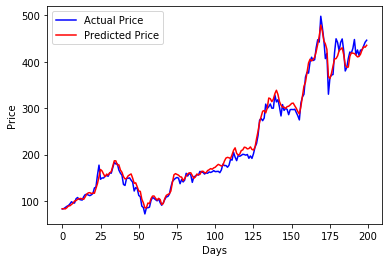

In [19]:
plot_graph(model, data)

In [20]:
def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)

In [21]:
print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))

1: Accuracy Score: 0.5357142857142857
